In [1]:
from parse_data import get_data


df = get_data()

In [2]:
df["creation_time"][0] - df["creation_time"][1]

-427061

In [3]:
average_diff = 0

c_time = df["creation_time"]

for i in range(1, len(c_time)):
    average_diff += c_time[i] - c_time[i-1]
average_diff/(len(c_time)-1)

1582.8439455281562

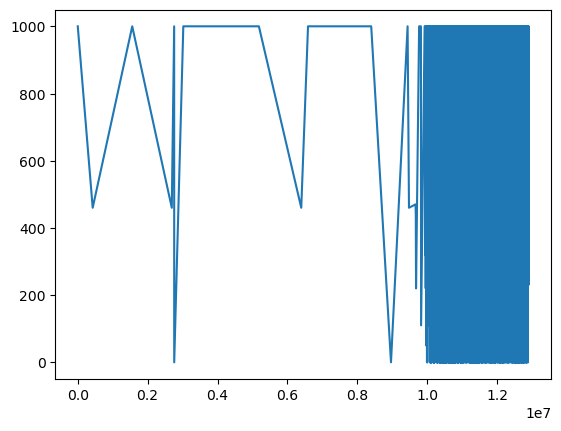

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()


ax.plot(df["creation_time"], df["gpu_milli"])

In [5]:
import torch.nn as nn


class PredictTime(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.hidden_size = 100
        self.hidden_layers = 5
        self.lstm = nn.LSTM(input_size=1, hidden_size=self.hidden_size, num_layers=self.hidden_layers).double()
        self.linear = nn.Linear(self.hidden_size,1).double()
        self.h_0 = torch.zeros(self.hidden_layers,self.hidden_size).double()
        self.c_0 = torch.zeros(self.hidden_layers,self.hidden_size).double()
        self.hidden = (self.h_0, self.c_0)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x, self.hidden = self.lstm(x,self.hidden)
        x = self.linear(x)
        return self.sig(x)
    
    def init_state(self):
        self.h_0 = self.hidden[0].detach()
        self.c_0 = self.hidden[1].detach()
        self.hidden = (self.h_0, self.c_0)
    
    def clean_state(self):
        self.h_0 = torch.zeros(self.hidden_layers,self.hidden_size).double()
        self.c_0 = torch.zeros(self.hidden_layers,self.hidden_size).double()
        self.hidden = (self.h_0, self.c_0)
       

In [6]:
import torch

def make_data(df):
    
    x_train, y_train = [], []
    prev = -1
    
    m = df.max()[0]
    print("Max value: ", m)
    
    for row in df.values:
        x_train.append([prev/m])
        y_train.append([row[0]/m])
        prev = row[0]
    return torch.tensor(x_train, dtype=torch.double),torch.tensor(y_train, dtype=torch.double)

make_data(df)
        

Max value:  1000


(tensor([[-0.0010],
         [ 1.0000],
         [ 0.4600],
         ...,
         [ 1.0000],
         [ 0.4600],
         [ 0.5900]], dtype=torch.float64),
 tensor([[1.0000],
         [0.4600],
         [1.0000],
         ...,
         [0.4600],
         [0.5900],
         [0.5900]], dtype=torch.float64))

In [7]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data
from IPython.display import clear_output

model = PredictTime()
optimizer = optim.Adam(model.parameters())
loss = nn.MSELoss()
batch_size = 100
x_d, y_d = make_data(get_data())
loader = data.DataLoader(data.TensorDataset(x_d,y_d), batch_size=batch_size)
epochs = 100000
for e in range(epochs):
    model.train()
    #print(next(iter(loader)))
    model.clean_state()
    for x, y in loader:
        
        #print("XXXX", x, "YYYY", y)
        
        model.init_state()
        y_pred = model(x.double())
        #print(y_pred, y)
        l = loss(y_pred, y)
        #print(l, np.sqrt(l.detach().numpy()))
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    if e % 10 != 0:
        continue
    #clear_output(wait=True)
    sum_loss = 0

    for x, y in loader:
        model.eval()
        with torch.no_grad():
            y_pred = model(x)
            sum_loss += np.sqrt(loss(y_pred, y))
    
    print("Epoch %d Loss %.4f" % (e, sum_loss))
    
    
#for d in df.values:


Max value:  1000
Epoch 0 Loss 29.6553
Epoch 10 Loss 29.5878
Epoch 20 Loss 28.4215
Epoch 30 Loss 28.2890
Epoch 40 Loss 28.0304
Epoch 50 Loss 27.9311
Epoch 60 Loss 25.7588
Epoch 70 Loss 24.4637
Epoch 80 Loss 20.5884
Epoch 90 Loss 17.5691
Epoch 100 Loss 13.7328
Epoch 110 Loss 11.4784
Epoch 120 Loss 7.7751
Epoch 130 Loss 8.1317
Epoch 140 Loss 7.5403
Epoch 150 Loss 6.6960
Epoch 160 Loss 5.7137
Epoch 170 Loss 7.9958
Epoch 180 Loss 4.1933
Epoch 190 Loss 5.0790
Epoch 200 Loss 4.9790
Epoch 210 Loss 5.5240
Epoch 220 Loss 3.4788
Epoch 230 Loss 4.1579
Epoch 240 Loss 4.0871
Epoch 250 Loss 5.4993
Epoch 260 Loss 3.3431
Epoch 270 Loss 3.8262
Epoch 280 Loss 4.0869
Epoch 290 Loss 6.0222
Epoch 300 Loss 2.9871
Epoch 310 Loss 3.1596
Epoch 320 Loss 3.4511
Epoch 330 Loss 3.0836
Epoch 340 Loss 3.4870
Epoch 350 Loss 2.4744
Epoch 360 Loss 4.1055
Epoch 370 Loss 3.3750
Epoch 380 Loss 3.3816
Epoch 390 Loss 4.6352
Epoch 400 Loss 2.5311
Epoch 410 Loss 2.2132
Epoch 420 Loss 2.4254
Epoch 430 Loss 3.0075
Epoch 440 Loss

KeyboardInterrupt: 

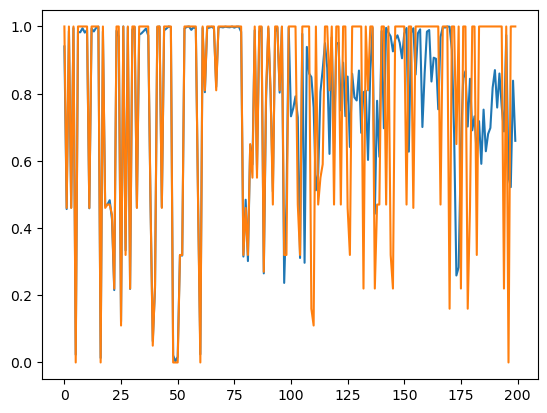

In [29]:
import matplotlib.pyplot as plt

def eval_model(x,y,m):
    res = []
    m.eval()
    m.clean_state()

    val = x[0]
    for _ in x:
        t = torch.tensor([[val]])
        val = m(t)
        res.append(val.detach().numpy()[0])
    
    fig, ax = plt.subplots()
    
    ax.plot(res)
    ax.plot(y)

amount = 200
eval_model(x_d[:amount],y_d[:amount],model)
